In [1]:
import sys
from pathlib import Path

venti_src_path = Path('/u/duvel-d2/govorcin/NJ/ASC/GNSS/Venti/src')
sys.path.append(str(venti_src_path))

In [2]:
import os 
os.chdir('/u/duvel-d2/govorcin/NJ/ASC/8622/CAL')

In [3]:
import numpy as np
import geopandas as gpd
from pathlib import Path

from scipy import interpolate
from shapely.geometry import Polygon
from skimage.filters import gaussian

# Calibration 
import venti.calibration.utils as cud
from venti.solvers.solvers import hamming2d_filter
from venti.calibration.calibration import (insar_referencing, 
                                           get_calibration_plane_fft, 
                                           get_fft_size, 
                                           disp_unit_vector)

# Mintpy
from mintpy.utils import readfile
from mintpy.utils import utils as ud
from mintpy.utils import writefile

# Plotting
from matplotlib import pyplot as plt
from matplotlib import colors
import contextily as cx
cmap = colors.ListedColormap(['red', 'black'])
bounds=[0,0.5,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [4]:
%load_ext autoreload
%autoreload 2

## Load Data

In [4]:
# InSAR
work_dir = Path('/u/duvel-d2/govorcin/NJ/ASC/8622/MINTPY')
file = work_dir / 'velocity.h5'
temp_var = work_dir / 'temp_variability.h5'
geom = work_dir / 'geometry.h5'
mask = work_dir / 'mask.h5'

velocity, attr = readfile.read(str(file), datasetName='velocity')
velocity *= 1e3
velocity = np.ma.masked_invalid(velocity).filled(0)

velocity_std = readfile.read(str(file), datasetName='velocityStd')[0]* 1e3
velocity_std = np.ma.masked_invalid(velocity_std).filled(0)
inc = readfile.read(str(geom), datasetName='incidenceAngle')[0]
az = readfile.read(str(geom), datasetName='azimuthAngle')[0] 
msk = readfile.read(str(mask), datasetName='mask')[0] 

snwe = ud.four_corners(attr)
extent = [snwe[2], snwe[3], snwe[0], snwe[1]]
extent

[464040.0, 751650.0, 4398570.0, 4637340.0]

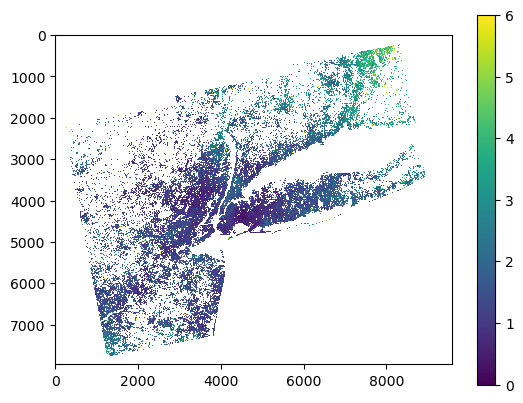

In [5]:
tvar = readfile.read(str(temp_var), datasetName='dV')[0]* 1e3
plt.imshow(np.ma.masked_array(tvar,mask=msk),
           interpolation='nearest', clim=[0,6])
plt.colorbar()

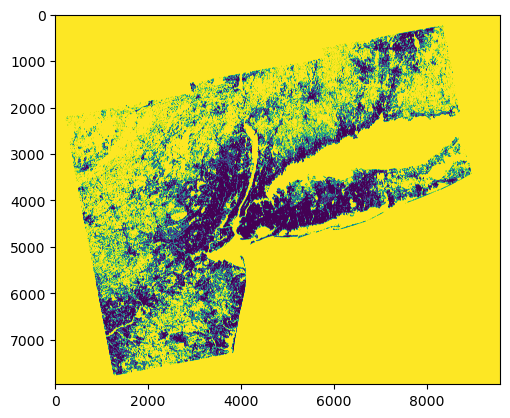

In [6]:
plt.imshow(msk)

In [7]:
# GNSS model
gnss_model = gpd.read_file('/u/duvel-d2/govorcin/NJ/ASC/GNSS/gnss_grid_30_midas_2000_2024')

#faults = gpd.read_file('zip:///u/trappist-r0/govorcin/06_PAPERS/VLM_CA/05_Figures/ca_faults.zip')

In [8]:
from pyproj import Transformer
# Init projection converter 
transformer = Transformer.from_crs( "EPSG:4326", f"EPSG:{attr['EPSG']}", always_xy=True)

points_latlon = [(d.lon, d.lat) for _, d in gnss_model.iterrows()]
points_utm = list(transformer.itransform(points_latlon))

In [9]:
gnss_model

ew        ns       sew       sns plate        lon        lat  \
0   -14.547650  4.061803  0.652882  0.768978    NA -81.642569  32.003705   
1   -14.495346  4.029698  0.647607  0.763705    NA -81.115828  32.032936   
2   -14.442961  4.003169  0.641960  0.757983    NA -80.588746  32.059683   
3   -14.395115  3.987093  0.636686  0.752624    NA -80.061352  32.083942   
4   -14.356522  3.985578  0.632544  0.748446    NA -79.533675  32.105710   
..         ...       ...       ...       ...   ...        ...        ...   
641 -15.490956  5.433043  0.560993  0.667312    NA -70.283380  44.702510   
642 -15.421609  5.362654  0.578534  0.687191    NA -69.654711  44.675475   
643 -15.334228  5.222216  0.602073  0.714152    NA -69.026642  44.645203   
644 -15.247418  5.066069  0.622764  0.737287    NA -68.399239  44.611701   
645 -15.170338  4.921356  0.638121  0.753869    NA -67.772567  44.574977   

      plate_ew  plate_ns  plate_up         v        sv  \
0   -12.908193  2.390360  0.007205 -0.584579  0.843522   
1   -12.904786  2.586265  0.007800 -0.582075  0.843504   
2   -12.899661  2.782079  0.008394 -0.579568  0.843472   
3   -12.892820  2.977773  0.008988 -0.578294  0.843429   
4   -12.884263  3.173318  0.009582 -0.579507  0.843386   
..         ...       ...       ...       ...       ...   
641 -15.708738  6.538243  0.021956 -0.600391  0.837686   
642 -15.651410  6.761890  0.022707 -0.605923  0.839821   
643 -15.591726  6.984512  0.023454 -0.600367  0.842084   
644 -15.529715  7.206063  0.024198 -0.594889  0.843105   
645 -15.465408  7.426496  0.024937 -0.591781  0.843424   

                       geometry  
0    POINT (-81.64257 32.00370)  
1    POINT (-81.11583 32.03294)  
2    POINT (-80.58875 32.05968)  
3    POINT (-80.06135 32.08394)  
4    POINT (-79.53368 32.10571)  
..                          ...  
641  POINT (-70.28338 44.70251)  
642  POINT (-69.65471 44.67548)  
643  POINT (-69.02664 44.64520)  
644  POINT (-68.39924 44.61170)  
645  POINT (-67.77257 44.57498)  

[646 rows x 13 columns]

In [10]:
length, width = velocity.shape
lats, lons = np.mgrid[snwe[1]:snwe[0]:length*1j,
                              snwe[2]:snwe[3]:width*1j]


gps_interpolated = dict(ew=None, ns=None, v=None, se=None, sn=None, sv=None)
for gps_data, key in zip([gnss_model.ew.values, gnss_model.ns.values,
                          gnss_model.v.values, gnss_model.sew.values,
                          gnss_model.sns.values, gnss_model.sv.values],
                         ['ew','ns','v','sn','se','sv']):
    
    gps_interpolated[key] = interpolate.griddata((np.vstack(points_utm)[:,1], np.vstack(points_utm)[:,0]),
                                                  gps_data,
                                                  (lats, lons),
                                                  method='linear', 
                                                  fill_value=np.nan)
    
# Get LOS displacement vector in NS, EW, UD direction
dn, de, dv = disp_unit_vector(inc, az)

# Project GNSS to InSAR LOS
gnss_los = np.array(np.multiply(gps_interpolated['ew'], de)
                    + np.multiply(gps_interpolated['ns'], dn) 
                    + np.multiply(gps_interpolated['v'], dv))

gnss_los_std = np.sqrt(np.multiply(gps_interpolated['se'], np.abs(de))**2
                        + np.multiply(gps_interpolated['sn'], np.abs(dn))**2 
                        + np.multiply(gps_interpolated['sv'], np.abs(dv)))**2

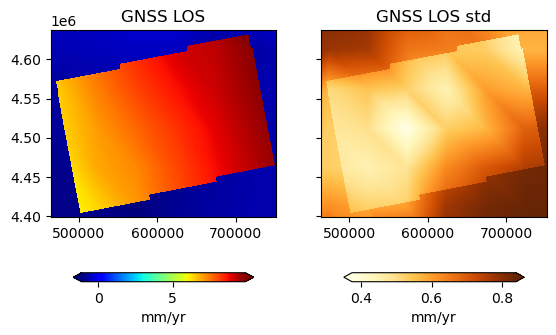

In [11]:
fig, ax = plt.subplots(1,2, sharey=True)
im1 = ax[0].imshow(np.ma.masked_equal(gnss_los, 0),
                   interpolation='nearest', cmap='jet', extent=extent)

im2 = ax[1].imshow(np.ma.masked_equal(gnss_los_std, 0),
                   interpolation='nearest', cmap='YlOrBr', extent=extent)
for i, a, txt in zip([im1, im2], ax, ['GNSS LOS', 'GNSS LOS std']):
    fig.colorbar(i, ax=a, location='bottom', shrink=0.8,
                 label='mm/yr',extend='both')
    a.set_title(txt)
    a.set_xlim(extent[:2])
    a.set_ylim(extent[2:])

In [12]:
import pyproj 
def _find_utm_zone(snwe:list):
    utm_crs_list = pyproj.database.query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=pyproj.aoi.AreaOfInterest(
        west_lon_degree=snwe[2],
        south_lat_degree=snwe[0],
        east_lon_degree=snwe[3],
        north_lat_degree=snwe[1],),
    )
    return pyproj.CRS.from_epsg(utm_crs_list[0].code)

def _get_buffer_around_fault(fault_df, distance, utm_crs):
    'Distance in meters'
    fault = fault_df.to_crs(utm_crs)
    buffer = fault.buffer(distance)
    return buffer.to_crs(4326)


def _get_mask_within_polygons(insar_lons, insar_lats, polygon):
    # Convert lon lat grid to geoseries
    insar_lalo = gpd.points_from_xy(insar_lons.ravel(),
                                    insar_lats.ravel())
    df = gpd.GeoDataFrame([],
                        geometry = insar_lalo,
                        crs='EPSG:4326')

    # Find points within polygons
    ik = []
    for ix, segment in enumerate(polygon):
        if segment != None:
            ik.append(df[df.within(polygon[ix])].index)
    # Merge and find unique indexs
    ik = [np.squeeze(np.array(ip)) for ip in ik if ip.shape[0] > 0]
    ik = np.unique(np.concatenate(ik))

    # Init mask
    mask = np.zeros_like(insar_lons.ravel())
    mask[ik] = 1
    return mask.reshape(insar_lons.shape)

In [13]:
## Get mask, adjust thresholds
tvar_th = np.nanpercentile(np.ma.masked_array(tvar,mask=msk).filled(np.nan), 98)
print(tvar_th) 
mask =  np.ma.masked_greater(np.ma.masked_array(tvar, mask=msk), tvar_th).mask
wmask = np.ma.masked_equal(velocity,0).mask
insar_gnss_res = np.ma.masked_array(velocity, mask=(mask | wmask)) - gnss_los
#th_below = insar_gnss_res < np.nanquantile(insar_gnss_res.filled(np.nan), 0.1)
#th_above = insar_gnss_res > np.nanquantile(insar_gnss_res.filled(np.nan), 0.98)

# Change 0 to nan to avoid interpolation outside of track
#insar_gnss_res = insar_gnss_res.filled(fill_value=np.nan)

#masked = np.ma.masked_where(th_below | th_above, insar_gnss_res)
masked = insar_gnss_res.copy()
fft_mask = masked.mask

4.139243907928467


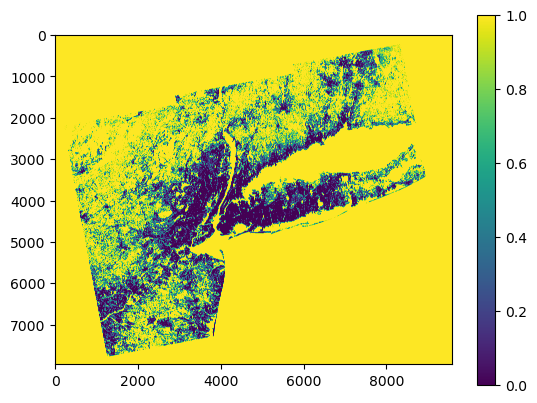

In [14]:
plt.imshow(mask)
plt.colorbar()

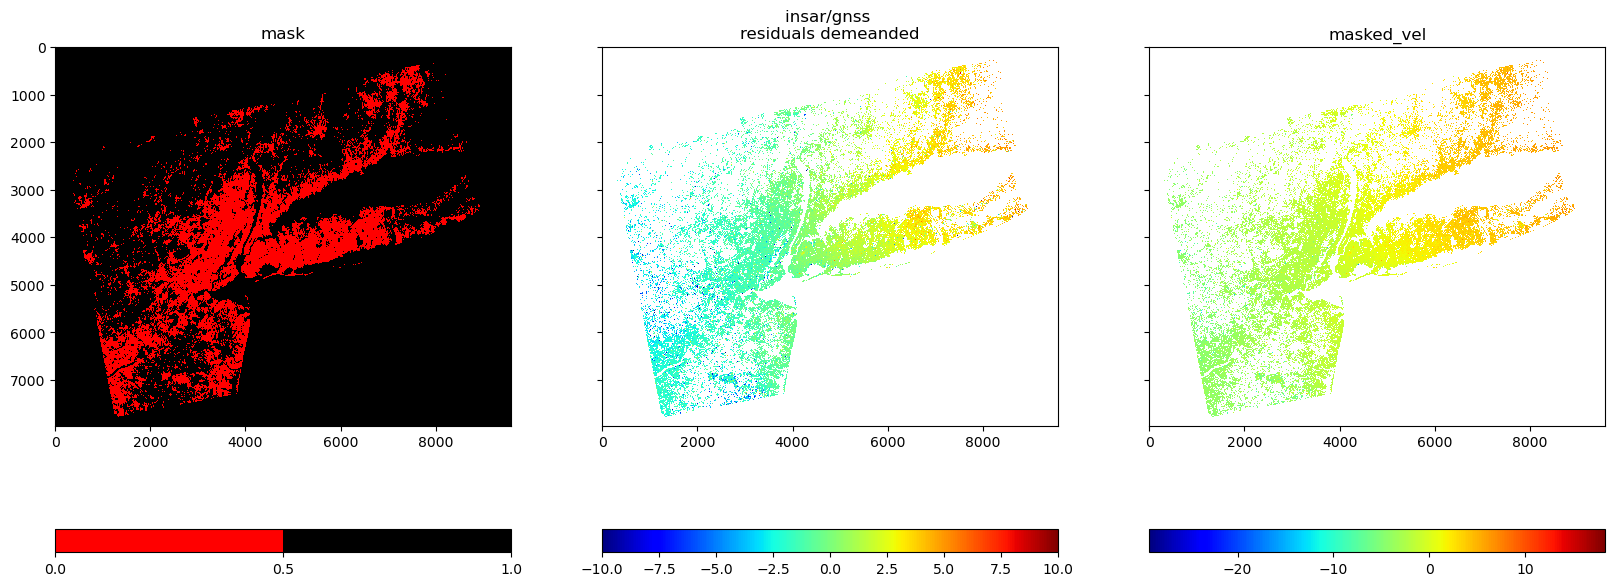

In [15]:
## PLOT
fig, ax = plt.subplots(1,3,sharey=True, figsize=(20,9))
im1 = ax[0].imshow(fft_mask, cmap=cmap, norm=norm)
im2 = ax[1].imshow(insar_gnss_res - np.mean(insar_gnss_res), 
                clim=[-10, 10],interpolation='nearest', cmap='jet')
im3 = ax[2].imshow(np.ma.masked_array(velocity, mask=fft_mask),
                   interpolation='nearest', cmap='jet')
im = [im1, im2, im3]
txt = ['mask', 'insar/gnss \nresiduals demeanded', 'masked_vel']
for a, i, t in zip(ax, im, txt):
    fig.colorbar(i, ax=a, location='bottom')
    a.set_title(t)

In [16]:
atrV = dict(attr)
unit = atrV['UNIT']
atrV['FILE_TYPE'] = 'velocity'
atrV['UNIT'] = 'mm/year'
output = 'residual_plane.h5'
length, width = velocity.shape
ds_dict = dict(insar_gnss=[np.float32, (length, width), None])
writefile.layout_hdf5(output,
                      metadata=atrV,
                      ds_name_dict=ds_dict)
writefile.write_hdf5_block(output,
                            data=insar_gnss_res.filled(0),
                            datasetName='insar_gnss')

--------------------------------------------------
create HDF5 file: residual_plane.h5 with w mode
create dataset  : insar_gnss of <class 'numpy.float32'>   in size of (7959, 9587)         with compression = None
close  HDF5 file: residual_plane.h5


--------------------------------------------------
open  HDF5 file residual_plane.h5 in a mode
writing dataset /insar_gnss                block: [0, 7959, 0, 9587]
close HDF5 file residual_plane.h5.


'residual_plane.h5'

 ## Calibration plane with FFT

Referencing InSAR with respect to GNSS
 ## Mask pixels with 0
 ## Use mask input!
 ## Fill gaps using gdal!


/u/trappist-r0/govorcin/src/tools/conda/envs/insar2/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


 ## Run FFT filtering:!
 ## Kernel: x_size: 20,  y_size: 20
 ## Kernel: cutoff: 1.2, rotation: -12.67 deg


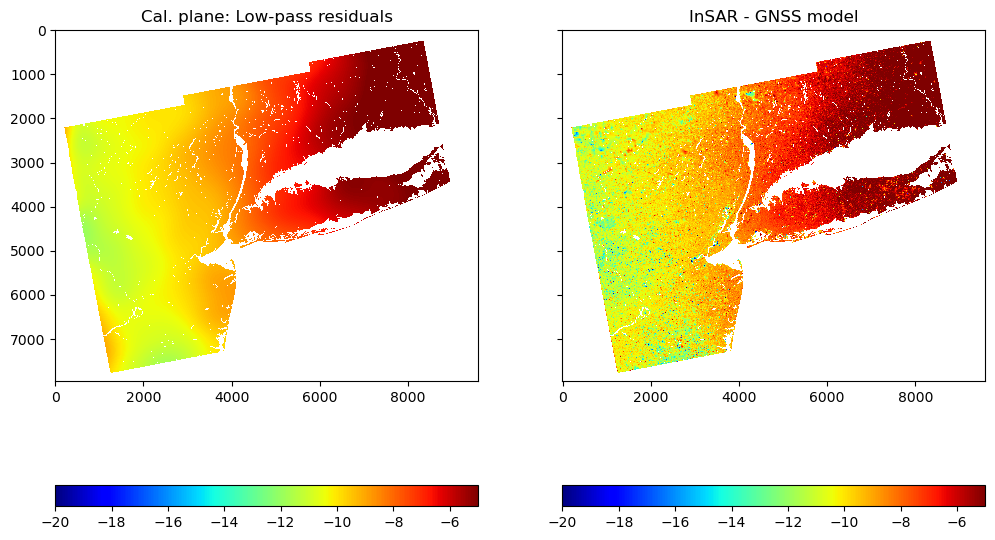

In [17]:
filtering_wavelength = 20e3 # m
cut_off = 30/25

#win_x, win_y = get_fft_size(attr, filtering_wavelength)
win_x, win_y = 20, 20

# satellite heading
angle = -12.67 #, np.float32(attr['HEADING'])
mask = np.ma.masked_equal(velocity,0).mask
fft_cal, res_cal = get_calibration_plane_fft(velocity, gnss_los,
                                             win_x, win_y, cut_off,
                                             mask=fft_mask,
                                             rotate_kernel=angle,
                                             gap_fill=True,
                                             nodata=0)

# Mask the output
fft_cal = np.ma.masked_array(fft_cal, mask=mask)
res_cal = np.ma.masked_array(res_cal, mask=mask)

# Plot
fig, ax = plt.subplots(1,2, figsize=(12,9), sharey=True)
im1 = ax[0].imshow(fft_cal, cmap='jet', interpolation='nearest', clim=[-20, -5])
im2 = ax[1].imshow(res_cal, cmap='jet', interpolation='nearest', clim=[-20, -5])
im = [im1, im2]

title = ['Cal. plane: Low-pass residuals', 'InSAR - GNSS model']
for i, a, txt in zip(im, ax, title):
    fig.colorbar(i, ax=a, location='bottom')
    a.set_title(txt)


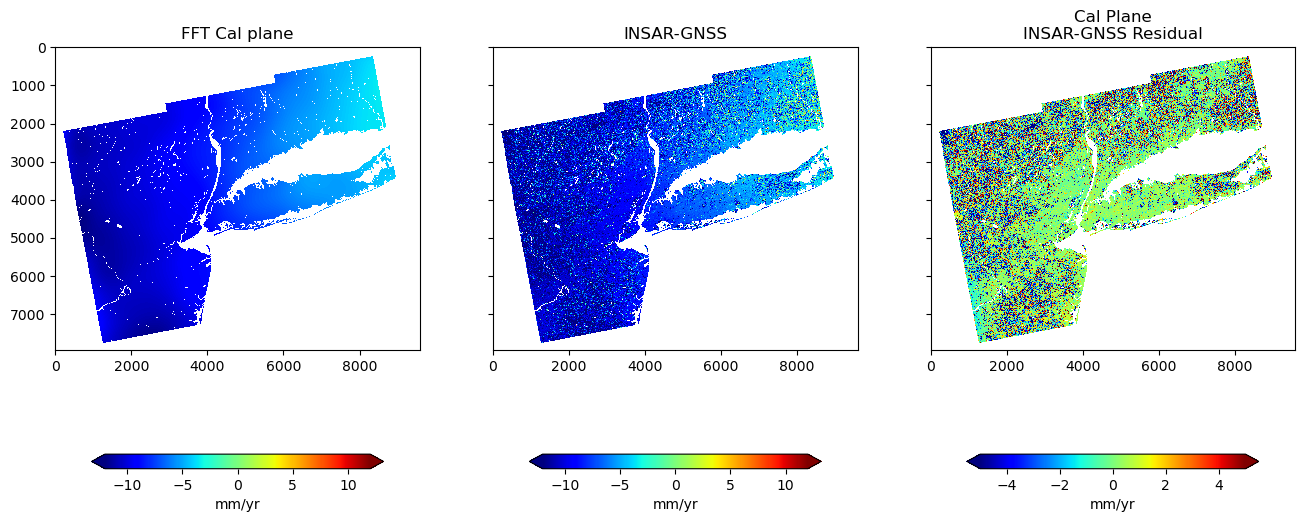

In [18]:
clim=[-12,12]
fig, ax = plt.subplots(1,3, figsize=(16,9), sharey=True)
im1 = ax[0].imshow(np.ma.masked_equal(fft_cal, 0), clim=clim,
                   interpolation='nearest', cmap='jet')
im2 = ax[1].imshow((np.ma.masked_equal(velocity,0) - gnss_los), clim=clim,
                   interpolation='nearest', cmap='jet')
im3 = ax[2].imshow((np.ma.masked_equal(velocity,0) - gnss_los) - np.ma.masked_equal(fft_cal, 0),
                   interpolation='nearest', cmap='jet', clim=[-5,5])
for i, a, txt in zip([im1, im2, im3], ax, ['FFT Cal plane', 'INSAR-GNSS', 
                                           'Cal Plane\nINSAR-GNSS Residual']):
    fig.colorbar(i, ax=a, location='bottom', shrink=0.8,
                 label='mm/yr',extend='both')
    a.set_title(txt)

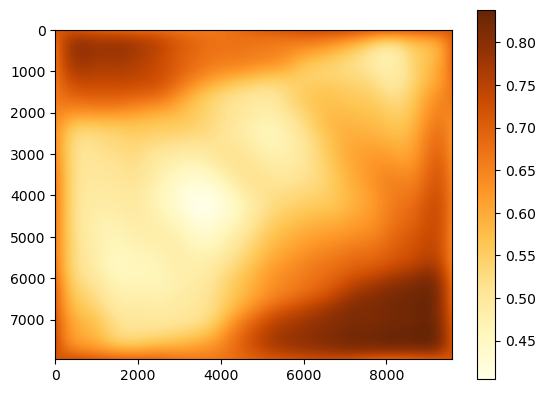

In [19]:
# STD
std_filled = cud.fill_gaps(np.ma.masked_invalid(gnss_los_std).filled(0),
                           smoothingIterations=2,
                           maxSearchDist=int(np.max(gnss_los_std.shape)))

filtered_std = hamming2d_filter(std_filled,
                                kernel_x=win_x,
                                kernel_y=win_y,
                                angle=angle, 
                                cut_off=cut_off)[0]

filtered_std = np.ma.masked_array(filtered_std,
                                  mask=np.ma.masked_invalid(gnss_los_std).mask).filled(0)

# Plot
plt.imshow(np.ma.masked_equal(filtered_std,0),
           interpolation='nearest', cmap='YlOrBr')
plt.colorbar()

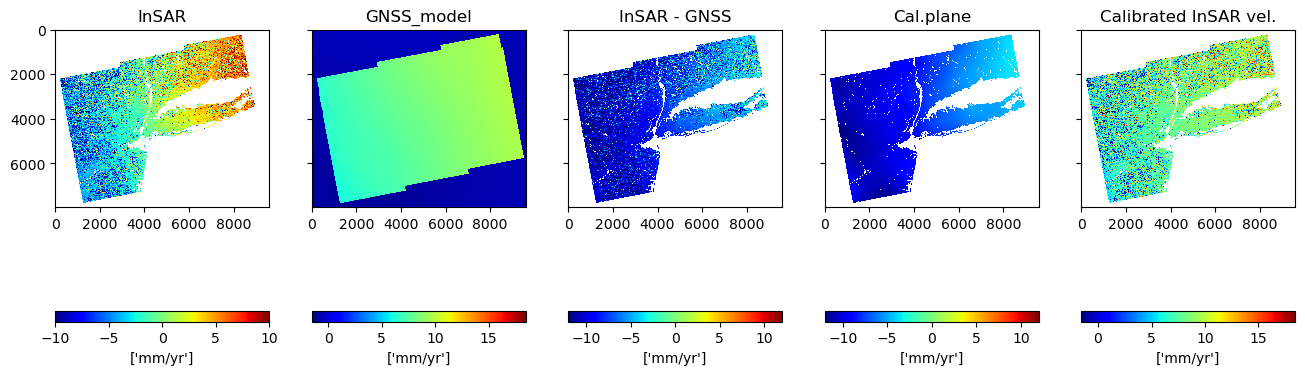

In [20]:
m2 = np.ma.masked_equal(fft_cal, 0)
mf = np.abs(np.nanmean(m2))

fig, ax = plt.subplots(1,5, figsize=(16, 9), sharey=True)
im1 = ax[0].imshow(np.ma.masked_equal(velocity,0), cmap='jet',
                   interpolation='nearest', clim=[-10, 10])
im2 = ax[1].imshow(gnss_los, cmap='jet', interpolation='nearest', 
                   clim=[-10+mf, 10+mf])
im3 = ax[2].imshow(np.ma.masked_equal(velocity,0) - gnss_los, clim=clim,
                   cmap='jet', interpolation='nearest')
im4 = ax[3].imshow(m2,
                   cmap='jet', interpolation='nearest', clim=clim)
im5 = ax[4].imshow(np.ma.masked_equal(velocity,0) - m2,
                   cmap='jet', interpolation='nearest',clim=[-10+mf, 10+mf])
titles = ['InSAR', 'GNSS_model','InSAR - GNSS', 
          'Cal.plane', 'Calibrated InSAR vel.']
for im , a, txt in zip([im1, im2, im3, im4, im5], ax, titles):
    fig.colorbar(im, ax=a,location='bottom', label=['mm/yr'])
    a.set_title(txt)

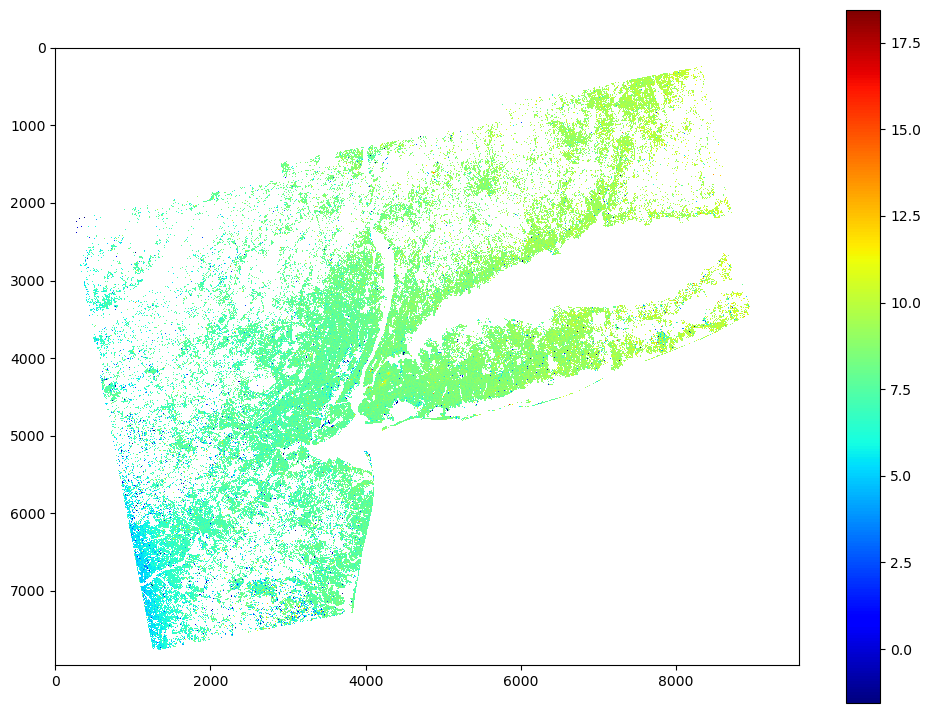

In [21]:
fig, ax = plt.subplots(1, figsize=(12,9))
im = ax.imshow(np.ma.masked_array(velocity,mask=msk) - m2,
                   cmap='jet', interpolation='nearest',
                   clim=[-10+mf, 10+mf])
fig.colorbar(im, ax=ax)

### output

In [22]:
calibrated_velocity_fft = np.ma.masked_array(velocity, mask=msk) - np.ma.masked_equal(fft_cal, 0)
comb_std_fft = np.sqrt(filtered_std**2 + velocity_std**2)
fft_cal = np.ma.masked_array(fft_cal, mask=np.ma.masked_equal(velocity,0).mask).filled(0)

In [23]:
atrV = dict(attr)
unit = atrV['UNIT']
atrV['FILE_TYPE'] = 'velocity'
atrV['UNIT'] = 'mm/year'
output = str('/u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5')
length, width = velocity.shape
ds_dict = dict(cal_velocity=[np.float32, (length, width), None], 
               cal_velocityStd=[np.float32, (length, width), None],
               cal_plane=[np.float32, (length, width), None])

writefile.layout_hdf5(output,
                      metadata=atrV,
                      ds_name_dict=ds_dict)

--------------------------------------------------
create HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5 with w mode
create dataset  : cal_velocity    of <class 'numpy.float32'>   in size of (7959, 9587)         with compression = None
create dataset  : cal_velocityStd of <class 'numpy.float32'>   in size of (7959, 9587)         with compression = None
create dataset  : cal_plane       of <class 'numpy.float32'>   in size of (7959, 9587)         with compression = None
close  HDF5 file: /u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5


'/u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5'

In [24]:
writefile.write_hdf5_block(output,
                            data=calibrated_velocity_fft.filled(fill_value=0),
                            datasetName='cal_velocity')
writefile.write_hdf5_block(output,
                            data=comb_std_fft,
                            datasetName='cal_velocityStd')
writefile.write_hdf5_block(output,
                            data=fft_cal,
                            datasetName='cal_plane')

--------------------------------------------------
open  HDF5 file /u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5 in a mode
writing dataset /cal_velocity              block: [0, 7959, 0, 9587]
close HDF5 file /u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5.
--------------------------------------------------
open  HDF5 file /u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5 in a mode
writing dataset /cal_velocityStd           block: [0, 7959, 0, 9587]
close HDF5 file /u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5.
--------------------------------------------------
open  HDF5 file /u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5 in a mode
writing dataset /cal_plane                 block: [0, 7959, 0, 9587]
close HDF5 file /u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5.


'/u/duvel-d2/govorcin/NJ/ASC/8622/CAL/OPERA_CAL_8622.h5'

## Calibration plane with LOWESS 

In [64]:
# Moving windows
win_size_x = np.rint(835).astype(int) #  90 m spacing * 11.1 = 1 km
win_size_y = np.rint(835).astype(int)

win_x_overlap = int(win_size_x//1.2)
win_y_overlap = int(win_size_y//1.2)

win_x_extend = win_size_x//8
win_y_extend = win_size_y//8 # win_size_y//4

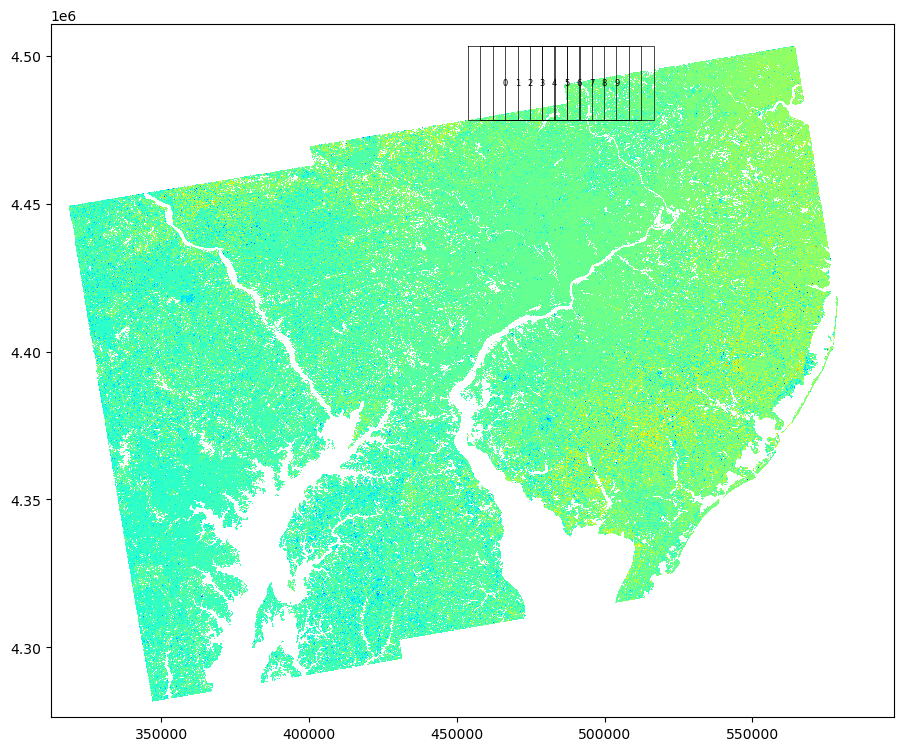

In [65]:
# Get windows
wins = cud.get_moving_windows(velocity,
                              win_size_x, win_size_y,
                              win_x_overlap, win_y_overlap)

#Get windows snwe extent
wins_snwe = [cud.get_window_snwe(attr,
                        win_y=[ix[0].start, ix[0].stop],
                        win_x=[ix[1].start, ix[1].stop])
                        for ix in wins]

# Create polygons and their centroids
polygons = [Polygon([[s[2], s[1]],
                     [s[3], s[1]],
                     [s[3], s[0]],
                     [s[2], s[0]],
                     [s[2], s[1]]])
                for s in wins_snwe[:10]]
centroids = [p.centroid.coords.xy for p in polygons]

# Plot windows
fig, ax = plt.subplots(1, figsize=(12,9))
ax.imshow(np.ma.masked_equal(velocity, 0),
          extent=cud.snwe_to_extent(snwe),
          interpolation='nearest', cmap='jet')
for c in polygons:
    ax.plot(*c.exterior.xy, color='black', lw=0.5)
    
labels = [ax.text(c[0][0]-0.06, c[1][0]+0.06, str(ii),
          horizontalalignment='center',
          verticalalignment='center', 
          fontsize=6) for ii, c in enumerate(centroids)]

In [66]:
gnss_model['x'] = np.vstack(points_utm)[:,0]
gnss_model['y'] = np.vstack(points_utm)[:,1]

In [ ]:
gnss_data = [gnss_model.ew.values, gnss_model.ns.values, 
             gnss_model.v.values, gnss_model.sew.values,
             gnss_model.sns.values, gnss_model.sv.values]

#gnss_latlon = (gnss_model.lat, gnss_model.lon)
gnss_latlon = (gnss_model.y, gnss_model.x)

cal_plane, cal_std = insar_referencing(velocity, velocity_std,
                                       inc, az,
                                       gnss_data, gnss_latlon, 
                                       win_size_x, win_size_y,
                                       win_x_overlap, win_y_overlap, # overlap
                                       win_x_extend, win_y_extend, #expand
                                       attr, mask=fft_mask,
                                       decimate=10, # 1km spacing
                                       poly_order=1.5) 

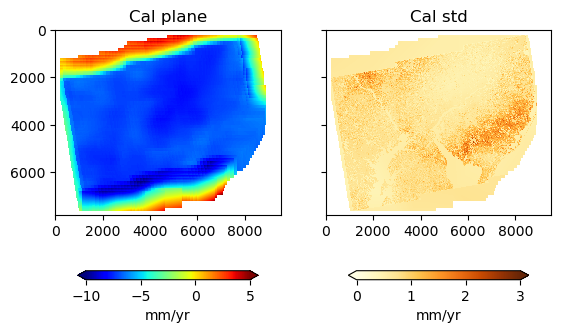

In [74]:
fig, ax = plt.subplots(1,2, sharey=True)
im1 = ax[0].imshow(np.ma.masked_equal(cal_plane, 0), clim=[-10,5],
                   interpolation='nearest', cmap='jet')
im2 = ax[1].imshow(np.ma.masked_equal(cal_std, 0),
                   interpolation='nearest', cmap='YlOrBr',clim=[0,3])
for i, a, txt in zip([im1, im2], ax, ['Cal plane', 'Cal std']):
    fig.colorbar(i, ax=a, location='bottom', shrink=0.8,
                 label='mm/yr',extend='both')
    a.set_title(txt)

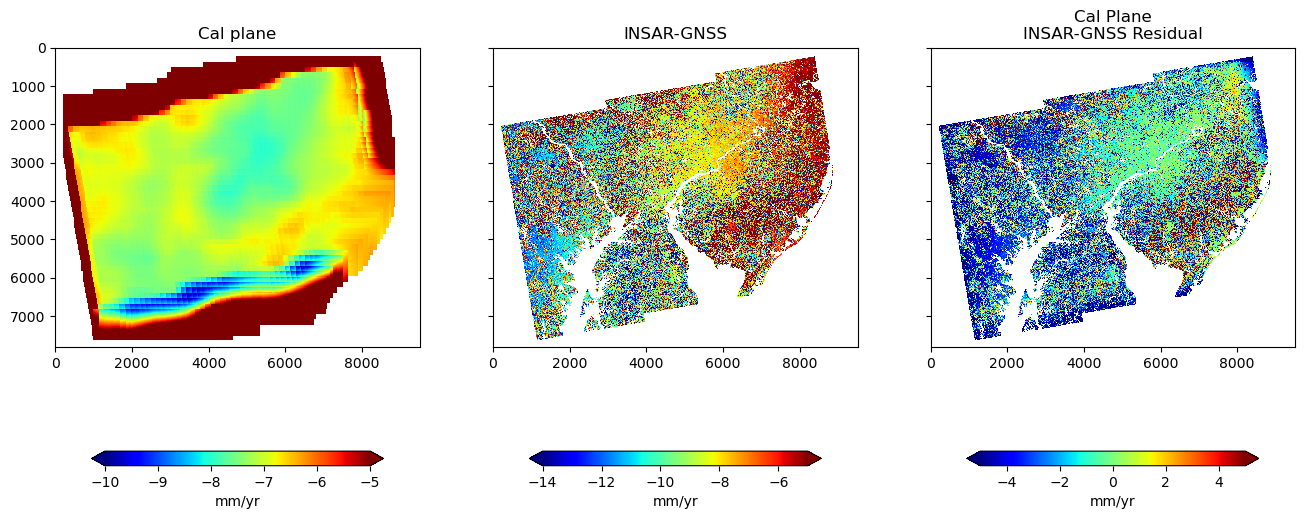

In [77]:
fig, ax = plt.subplots(1,3, figsize=(16,9), sharey=True)
im1 = ax[0].imshow(np.ma.masked_equal(cal_plane, 0), clim=[-10,-5],
                   interpolation='nearest', cmap='jet')
im2 = ax[1].imshow((np.ma.masked_equal(velocity,0) - gnss_los), clim=[-14,-5],
                   interpolation='nearest', cmap='jet')
im3 = ax[2].imshow((np.ma.masked_equal(velocity,0) - gnss_los) - np.ma.masked_equal(cal_plane, 0),
                   interpolation='nearest', cmap='jet', clim=[-5,5])
for i, a, txt in zip([im1, im2, im3], ax, ['Cal plane', 'INSAR-GNSS', 'Cal Plane\nINSAR-GNSS Residual']):
    fig.colorbar(i, ax=a, location='bottom', shrink=0.8,
                 label='mm/yr',extend='both')
    a.set_title(txt)

In [78]:
# Filter the edges
zero_mask = np.ma.masked_equal(velocity, 0).mask
# Fill outside to avoid edge artifacts
cal1 = cud.fill_gaps(cal_plane, smoothingIterations=0)

# Smooth
filt_cal = gaussian(cal1, (25, 25))

filt_cal = np.ma.masked_array(filt_cal, mask=zero_mask).filled(0)

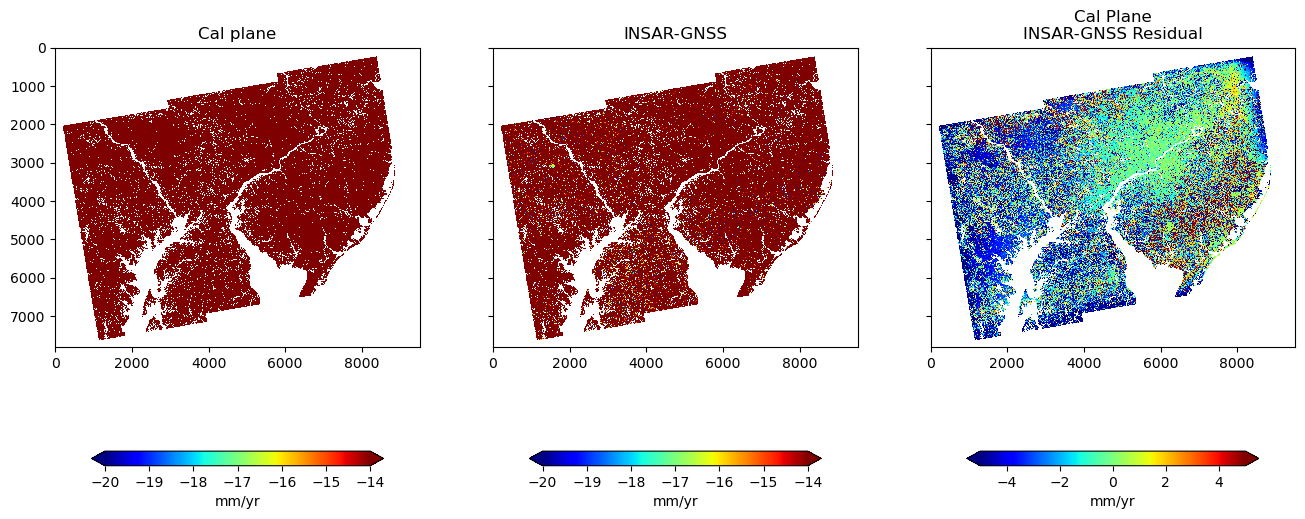

In [79]:
fig, ax = plt.subplots(1,3, figsize=(16,9), sharey=True)
im1 = ax[0].imshow(np.ma.masked_equal(filt_cal, 0), clim=[-20,-14],
                   interpolation='nearest', cmap='jet')
im2 = ax[1].imshow((np.ma.masked_equal(velocity,0) - gnss_los), clim=[-20,-14],
                   interpolation='nearest', cmap='jet')
im3 = ax[2].imshow((np.ma.masked_equal(velocity,0) - gnss_los) - np.ma.masked_equal(filt_cal, 0),
                   interpolation='nearest', cmap='jet', clim=[-5,5])
for i, a, txt in zip([im1, im2, im3], ax, ['Cal plane', 'INSAR-GNSS', 'Cal Plane\nINSAR-GNSS Residual']):
    fig.colorbar(i, ax=a, location='bottom', shrink=0.8,
                 label='mm/yr',extend='both')
    a.set_title(txt)

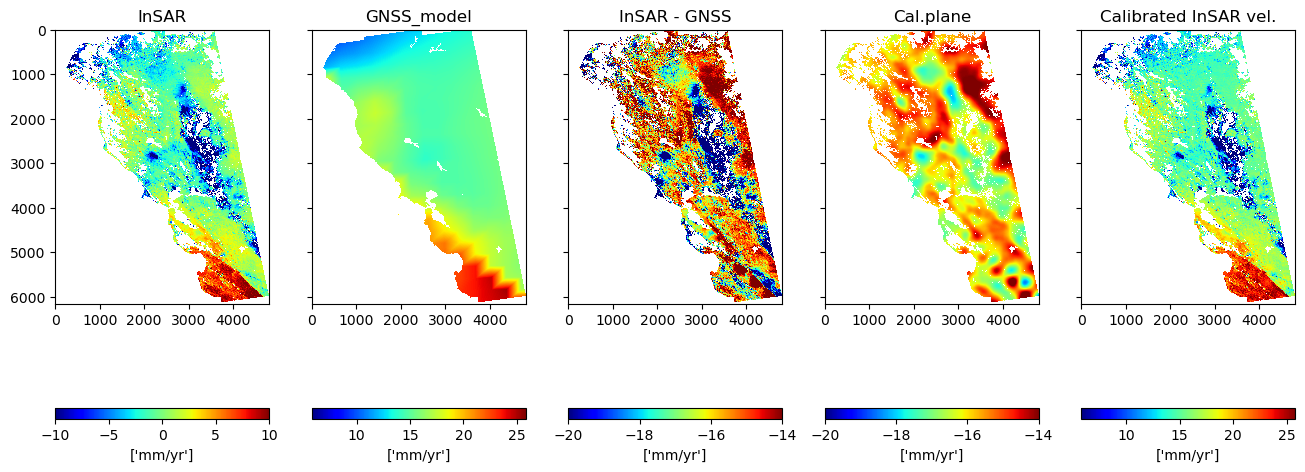

In [39]:
m2 = np.ma.masked_equal(filt_cal, 0)
mf = np.abs(np.nanmean(m2))

fig, ax = plt.subplots(1,5, figsize=(16,9), sharey=True)
im1 = ax[0].imshow(np.ma.masked_equal(velocity,0), cmap='jet',
                   interpolation='nearest', clim=[-10, 10])
im2 = ax[1].imshow(gnss_los, cmap='jet', interpolation='nearest', clim=[-10+mf, 10+mf])
im3 = ax[2].imshow(np.ma.masked_equal(velocity,0) - gnss_los, clim=[-20, -14],
                   cmap='jet', interpolation='nearest')
im4 = ax[3].imshow(m2,
                   cmap='jet', interpolation='nearest', clim=[-20, -14])
im5 = ax[4].imshow(np.ma.masked_equal(velocity,0) - m2,
                   cmap='jet', interpolation='nearest',clim=[-10+mf, 10+mf])
titles = ['InSAR', 'GNSS_model','InSAR - GNSS', 
          'Cal.plane', 'Calibrated InSAR vel.']
for im , a, txt in zip([im1, im2, im3, im4, im5], ax, titles):
    fig.colorbar(im, ax=a,location='bottom', label=['mm/yr'])
    a.set_title(txt)

## output

In [78]:
calibrated_velocity = np.ma.masked_equal(velocity, 0) - np.ma.masked_equal(masked_m2, 0)

In [79]:
atrV = dict(attr)
unit = atrV['UNIT']
atrV['FILE_TYPE'] = 'velocity'
atrV['UNIT'] = 'mm/year'
output = str(work_dir / '04_CALIBRATED/ASC/cal_A035.h5')
length, width = velocity.shape
ds_dict = dict(cal_velocity=[np.float32, (length, width), None], 
               cal_velocityStd=[np.float32, (length, width), None],
               cal_plane=[np.float32, (length, width), None])

writefile.layout_hdf5(output,
                      metadata=atrV,
                      ds_name_dict=ds_dict)

--------------------------------------------------
create HDF5 file: /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5 with w mode
create dataset  : cal_velocity    of <class 'numpy.float32'>   in size of (6170, 4807)         with compression = None
create dataset  : cal_velocityStd of <class 'numpy.float32'>   in size of (6170, 4807)         with compression = None
create dataset  : cal_plane       of <class 'numpy.float32'>   in size of (6170, 4807)         with compression = None
close  HDF5 file: /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5


'/u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5'

In [80]:
writefile.write_hdf5_block(output,
                            data=calibrated_velocity.filled(fill_value=0),
                            datasetName='cal_velocity')
writefile.write_hdf5_block(output,
                            data=cal_std,
                            datasetName='cal_velocityStd')
writefile.write_hdf5_block(output,
                            data=np.ma.masked_equal(masked_m2, 0),
                            datasetName='cal_plane')

--------------------------------------------------
open  HDF5 file /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5 in a mode
writing dataset /cal_velocity              block: [0, 6170, 0, 4807]
close HDF5 file /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5.
--------------------------------------------------
open  HDF5 file /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5 in a mode
writing dataset /cal_velocityStd           block: [0, 6170, 0, 4807]
close HDF5 file /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5.
--------------------------------------------------
open  HDF5 file /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5 in a mode
writing dataset /cal_plane                 block: [0, 6170, 0, 4807]
close HDF5 file /u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5.


'/u/trappist-r0/govorcin/02_ACCESS_ARIA/CA_VLM/FINAL/04_CALIBRATED/ASC/cal_A035.h5'

# COMPARISON

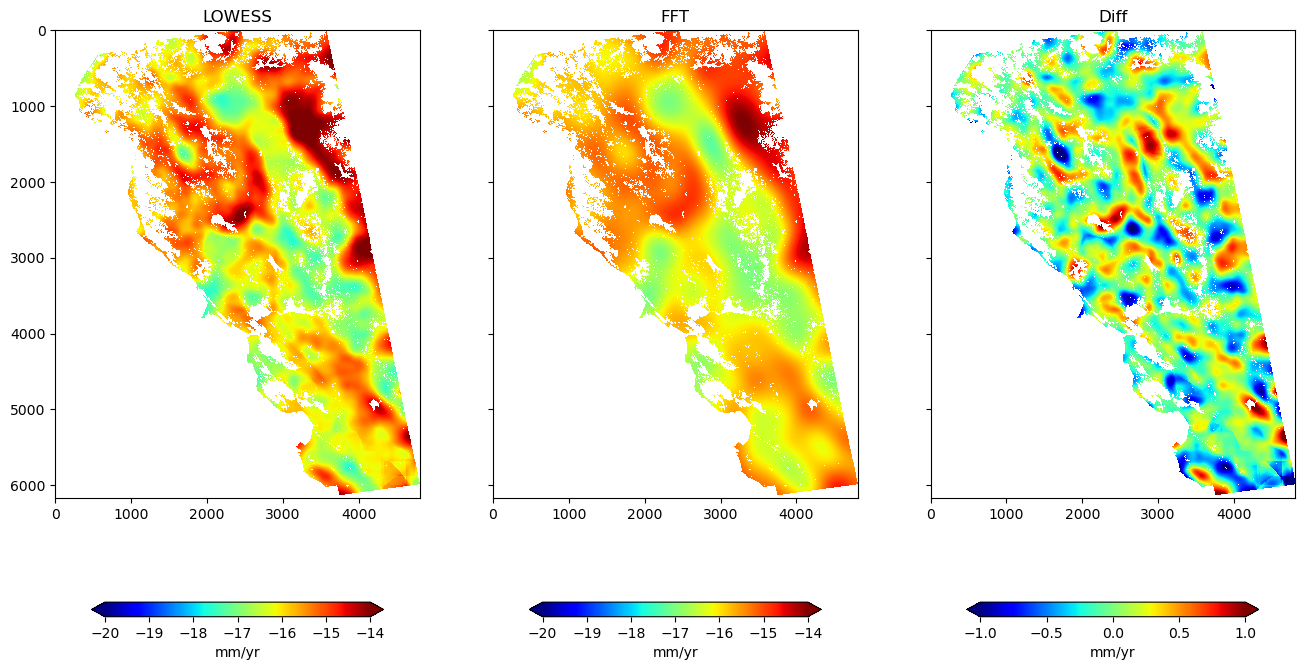

In [74]:
fig, ax = plt.subplots(1,3, figsize=(16,9), sharey=True)
im1 = ax[0].imshow(np.ma.masked_equal(masked_m2, 0), clim=[-20,-14],
                   interpolation='nearest', cmap='jet')
im2 = ax[1].imshow(np.ma.masked_equal(fft_cal,0) , clim=[-20,-14],
                   interpolation='nearest', cmap='jet')
im3 = ax[2].imshow(np.ma.masked_equal(masked_m2,0) - np.ma.masked_equal(fft_cal, 0),
                   interpolation='nearest', cmap='jet', clim=[-1,1])
for i, a, txt in zip([im1, im2, im3], ax, ['LOWESS','FFT', 'Diff']):
    fig.colorbar(i, ax=a, location='bottom', shrink=0.8,
                 label='mm/yr',extend='both')
    a.set_title(txt)

(array([5.2470000e+03, 1.4295000e+04, 8.1837000e+04, 5.0720000e+05,
        2.0429580e+06, 2.1897061e+07, 3.6122630e+06, 1.2461200e+06,
        2.4062800e+05, 1.1581000e+04]),
 array([-1.78229445, -1.47372716, -1.16515987, -0.85659258, -0.54802529,
        -0.239458  ,  0.06910929,  0.37767658,  0.68624387,  0.99481116,
         1.30337845]),
 <BarContainer object of 10 artists>)

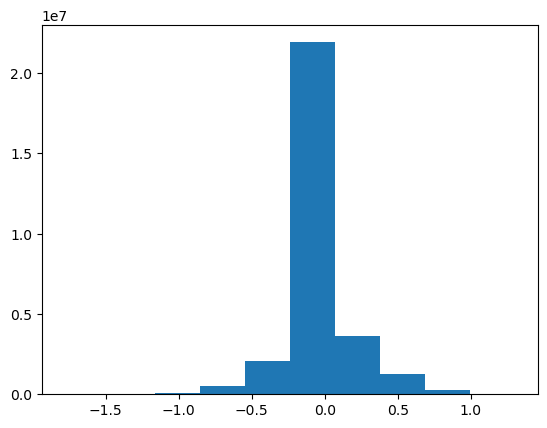

In [76]:
dif = np.ma.masked_equal(masked_m2,0) - np.ma.masked_equal(fft_cal, 0)
plt.hist(dif.ravel())

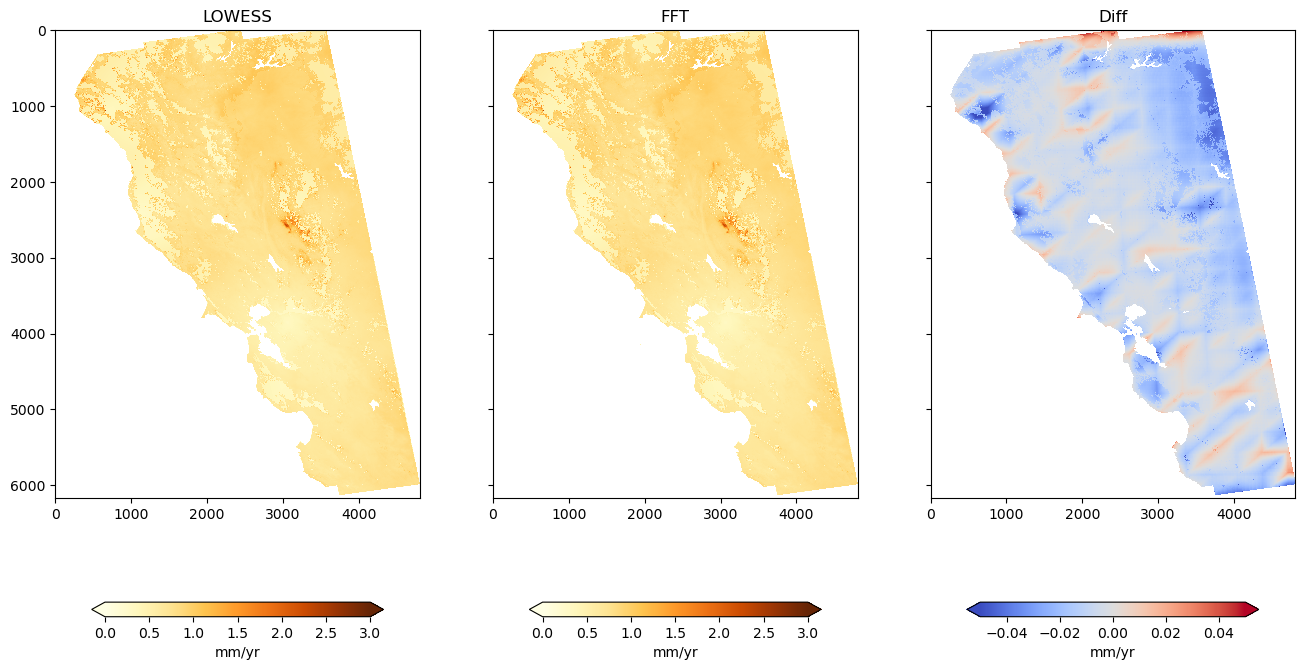

In [77]:
fig, ax = plt.subplots(1,3, figsize=(16,9), sharey=True)
im1 = ax[0].imshow(np.ma.masked_equal(cal_std, 0), clim=[0,3],
                   interpolation='nearest', cmap='YlOrBr')
im2 = ax[1].imshow(np.ma.masked_equal(comb_std_fft, 0) , clim=[0,3],
                   interpolation='nearest', cmap='YlOrBr')
im3 = ax[2].imshow(np.ma.masked_equal(cal_std,0) - np.ma.masked_equal(comb_std_fft, 0),
                   interpolation='nearest', cmap='coolwarm', clim=[-0.05,0.05])
for i, a, txt in zip([im1, im2, im3], ax, ['LOWESS','FFT', 'Diff']):
    fig.colorbar(i, ax=a, location='bottom', shrink=0.8,
                 label='mm/yr',extend='both')
    a.set_title(txt)